In [ ]:
!pip install psycopg2

In [ ]:
!pip install nltk

In [ ]:
!pip install tabulate


In [ ]:
from google.colab import drive

# Monta o Google Drive no Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import pandas as pd
import dask.dataframe as dd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from tabulate import tabulate

import numpy as np
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

In [ ]:
#file_path = '/content/drive/MyDrive/TCC/datasets/dataset_video_platform_links_unique.csv'
#file_path = '/content/drive/MyDrive/TCC/datasets/dataset_video_platform_links_all.csv'
file_path = '/content/drive/MyDrive/TCC/datasets/dataset_video_platform_links_all_reprocessed_1.csv'

# Lê o arquivo CSV do Google Drive para um DataFrame do Pandas
df = pd.read_csv(file_path)

In [ ]:
df['message_utc'] = pd.to_datetime(df['message_utc'])

In [ ]:
df.head()

,channel_id,author_id,message_data,message_utc,window_id
0,-1001034598292,126906048.0,https://www.youtube.com/watch?v=S265ilIKldk,2020-03-05 15:17:36,1
1,-1001034598292,126906048.0,e saiu o gameplay de final fantasy 7 galera,2020-03-05 15:17:35,1
2,-1001034598292,126906048.0,xfce é só amor,2020-03-05 15:17:24,1
3,-1001034598292,126906048.0,Gnome também é,2020-03-05 15:17:20,1
4,-1001034598292,126906048.0,Plasma é bom =D,2020-03-05 15:17:13,1


In [ ]:
len(df)

618986

In [ ]:
unique_messages = df['message_data'].nunique()
print(f'Número de mensagens únicas: {unique_messages}')

Número de mensagens únicas: 185778


In [ ]:
messages_by_window = df['window_id'].value_counts()
print('Número de mensagens por janela:\n')
print(messages_by_window)

Número de mensagens por janela:

78479     528
59254     404
84063     400
84096     366
78480     357
         ... 
177267      1
177266      1
177264      1
177263      1
164584      1
Name: window_id, Length: 140751, dtype: int64


In [ ]:
# Calculando a média
avg_messages_by_window = messages_by_window.mean()

print(f'Média de mensagens por janela: {avg_messages_by_window}')

Média de mensagens por janela: 4.39773784910942


In [ ]:
avg_words_per_message = df['message_data'].apply(lambda x: len(str(x).split())).mean()
print(f'Média de palavras por mensagem: {avg_words_per_message:.2f}')

Média de palavras por mensagem: 23.04


In [ ]:
select = df.loc[df['window_id'] == 78479]

select.head()

,channel_id,author_id,message_data,message_utc,window_id
117943,-1001399100023,1.540467e+09,https://www.youtube.com/watch?v=FCXd1mAjjkc,2022-11-05 02:13:08,78479
117944,-1001399100023,8.541382e+08,Meu Deus 😱😧,2022-11-05 02:13:08,78479
117945,-1001399100023,1.686224e+09,André daqui a pouco vão querer te derrubar tbm,2022-11-05 02:13:07,78479
117946,-1001399100023,1.241167e+09,Daqui a pouco derrubam o italo marsili tbm,2022-11-05 02:13:06,78479
117947,-1001399100023,1.169897e+09,Alguém tem que parar esse cabeça de ovo,2022-11-05 02:13:06,78479


In [ ]:
df.describe()

,channel_id,author_id,window_id
count,6.189860e+05,4.762400e+05,618986.000000
mean,-1.001414e+12,1.764073e+09,86484.701867
std,1.408678e+08,1.528244e+09,46243.490528
min,-1.001900e+12,1.434248e+06,1.000000
25%,-1.001490e+12,9.172776e+08,61278.000000
50%,-1.001457e+12,1.308222e+09,82310.000000
75%,-1.001329e+12,1.667736e+09,103937.000000
max,-1.001009e+12,5.988524e+09,191115.000000


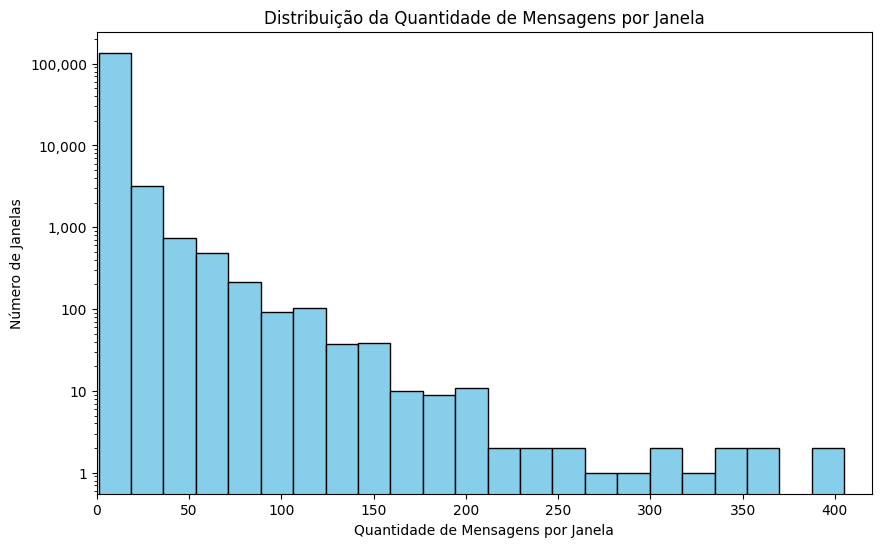

In [ ]:
# Calcule a contagem de mensagens por janela
message_count_by_window = df.groupby('window_id')['message_utc'].count().reset_index(name = 'message_count')

# Visualize a distribuição da quantidade de mensagens por janela com escala ajustada
plt.figure(figsize=(10, 6))
plt.hist(message_count_by_window['message_count'], bins = 30, color = 'skyblue', edgecolor = 'black')

# Ajusta os limites do eixo x para reduzir a proporção
plt.xlim(0, 420)
plt.yscale('log')  # Altera a escala do eixo y para logarítmica


plt.title('Distribuição da Quantidade de Mensagens por Janela')
plt.xlabel('Quantidade de Mensagens por Janela')
plt.ylabel('Número de Janelas')

plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

In [ ]:
ddf = dd.from_pandas(df, npartitions = 8)  # ajuste o número de partições conforme necessário

# Adiciona uma nova coluna 'tamanho_mensagem' ao DataFrame
ddf['message_length'] = ddf['message_data'].map(lambda x: len(str(x)), meta = ('message_data', 'int'))
df = ddf.compute()

Comprimento médio das mensagens: 172.47 caracteres


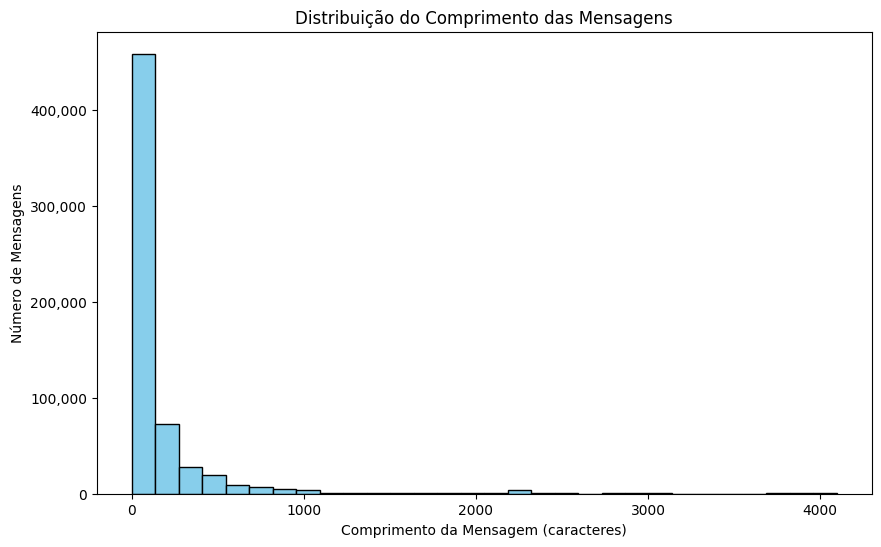

In [ ]:
# Calcule o comprimento médio das mensagens
average_length = ddf['message_length'].mean()

# Exiba o comprimento médio
print(f"Comprimento médio das mensagens: {average_length.compute():.2f} caracteres")

# Visualize a distribuição dos comprimentos das mensagens
plt.figure(figsize = (10, 6))
plt.hist(ddf['message_length'].compute(), bins = 30, color = 'skyblue', edgecolor = 'black')

plt.title('Distribuição do Comprimento das Mensagens')
plt.xlabel('Comprimento da Mensagem (caracteres)')
plt.ylabel('Número de Mensagens')

plt.gca().yaxis.set_major_formatter('{:,.0f}'.format)
plt.show()

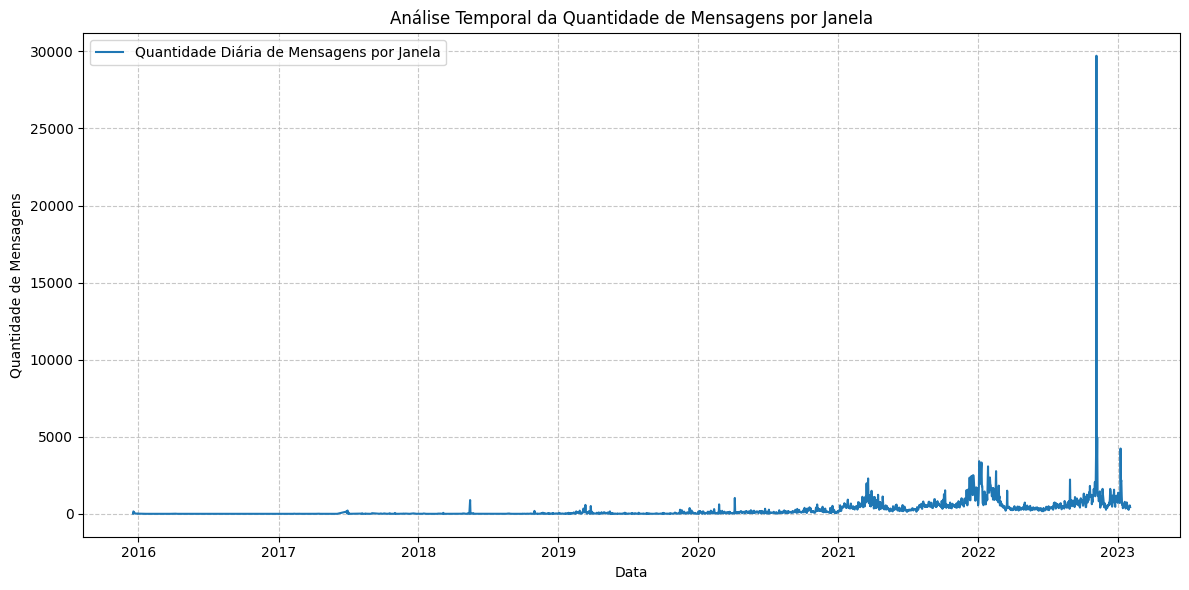

In [ ]:
# Agrupe os dados por janela e data, somando o número de mensagens em cada grupo
count_by_window_date = ddf.groupby(['window_id', ddf['message_utc'].dt.date]).size().compute().reset_index(name='message_count')
count_by_window_date['message_utc'] = pd.to_datetime(count_by_window_date['message_utc'])

# Soma a quantidade de mensagens por dia, independente da janela
daily_message_count = count_by_window_date.groupby('message_utc')['message_count'].sum().reset_index()

# Visualize a distribuição da quantidade de mensagens por dia ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(daily_message_count['message_utc'], daily_message_count['message_count'], label='Quantidade Diária de Mensagens por Janela')

plt.title('Análise Temporal da Quantidade de Mensagens por Janela')
plt.xlabel('Data')
plt.ylabel('Quantidade de Mensagens')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-13-16038781a4e7>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_avg = df.resample('D', on = 'message_utc').mean()


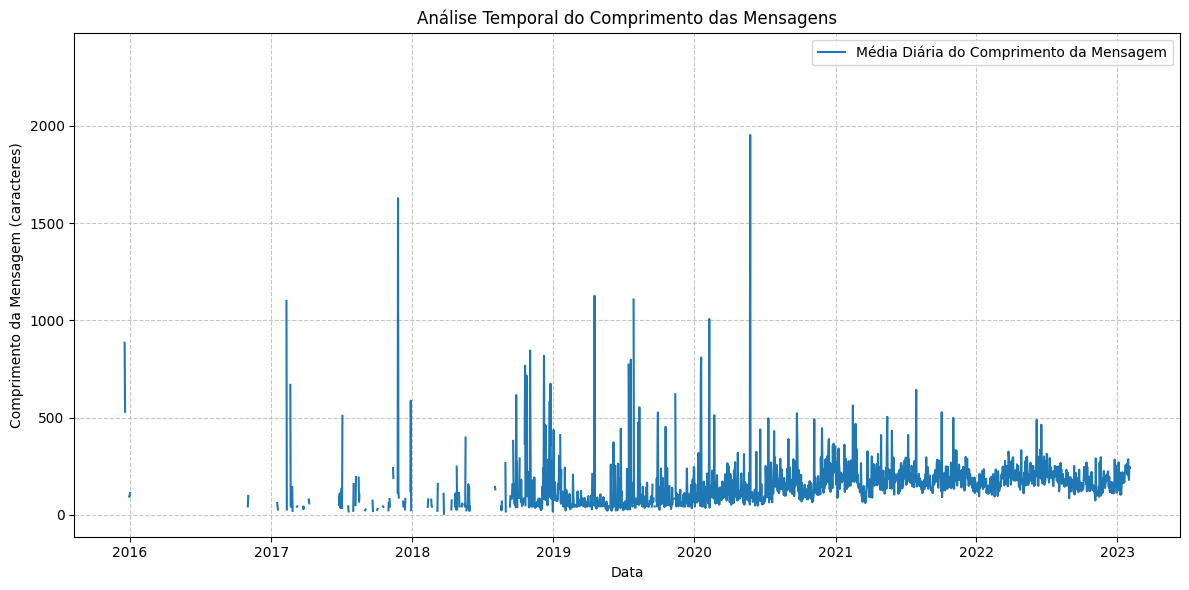

In [ ]:
# Agregar dados para média diária do comprimento da mensagem
daily_avg = df.resample('D', on = 'message_utc').mean()

# Plotar a média diária do comprimento da mensagem
plt.figure(figsize = (12, 6))
plt.plot(daily_avg['message_length'], label = 'Média Diária do Comprimento da Mensagem')

plt.title('Análise Temporal do Comprimento das Mensagens')
plt.xlabel('Data')
plt.ylabel('Comprimento da Mensagem (caracteres)')
plt.legend()

plt.grid(True, linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Calcular a quantidade de mensagens e a quantidade de usuários por janela
result_window = df.groupby('window_id').agg({
    'message_data': 'count',  # Contagem de mensagens
    'author_id': 'nunique'  # Contagem de usuários únicos
})

# Renomear as colunas para refletir a contagem
result_window.columns = ['message_count', 'user_count']

# Ordenar o DataFrame com base na média das mensagens em ordem decrescente
result_sorted = result_window.sort_values(by = 'message_count', ascending = False)

# Selecionar as 20 primeiras linhas
result_top_20 = result_sorted.head(20)

# Exibir a tabela resultante usando tabulate
table = tabulate(result_top_20, headers = 'keys', tablefmt = 'fancy_grid')

# Imprimir a tabela formatada
print(table)

╒═════════════╤═════════════════╤══════════════╕
│   window_id │   message_count │   user_count │
╞═════════════╪═════════════════╪══════════════╡
│       78479 │             528 │          120 │
├─────────────┼─────────────────┼──────────────┤
│       59254 │             396 │            2 │
├─────────────┼─────────────────┼──────────────┤
│       84063 │             368 │            9 │
├─────────────┼─────────────────┼──────────────┤
│       78480 │             357 │           62 │
├─────────────┼─────────────────┼──────────────┤
│       59255 │             336 │            2 │
├─────────────┼─────────────────┼──────────────┤
│       78481 │             330 │           55 │
├─────────────┼─────────────────┼──────────────┤
│       84096 │             322 │            6 │
├─────────────┼─────────────────┼──────────────┤
│       78482 │             312 │           53 │
├─────────────┼─────────────────┼──────────────┤
│       84064 │             292 │            7 │
├─────────────┼─────

In [ ]:
# Calcular a média e o desvio padrão de message_count e user_count
result_overall = result_window[['message_count', 'user_count']].agg(['mean', 'std']).transpose()

# Renomear as colunas para refletir a média e o desvio padrão
result_overall.columns = ['mean', 'std']

# Exibir as estatísticas resultantes
print(result_overall)

                   mean       std
message_count  4.037343  8.858479
user_count     1.422704  2.354134


In [ ]:
# Marcar mensagens com domínios
domains = ['youtube', 'odysee', 'rumble', 'bitchute']
df['domain'] = df['message_data'].str.extract(f"({'|'.join(domains)})", flags = re.IGNORECASE)

# Converter domínios para minúsculas
df['domain'] = df['domain'].str.lower()

# Função customizada para encontrar o valor não nulo mais comum em um grupo
def most_common_non_null(series):
    non_null_values = series.dropna()
    if non_null_values.empty:
        return np.nan
    return non_null_values.mode().iloc[0]

# Marcar o domain de todas as mensagens de um mesmo canal em uma mesma janela da mensagem identificada com domain
df['domain'] = df.groupby(['channel_id', 'window_id'])['domain'].transform(most_common_non_null)

# Contar mensagens, janelas e usuários por domínio
domain_stats = df.groupby('domain').agg(
    message_count = ('message_data', 'count'),
    window_count = ('window_id', 'nunique'),
    user_count = ('author_id', 'nunique')
).reset_index()

# Exibir resultados
print("Quantidade de mensagens, janelas e usuários por domínio:")
print(tabulate(domain_stats, headers = 'keys', tablefmt = 'fancy_grid'))

Quantidade de mensagens, janelas e usuários por domínio:
╒════╤══════════╤═════════════════╤════════════════╤══════════════╕
│    │ domain   │   message_count │   window_count │   user_count │
╞════╪══════════╪═════════════════╪════════════════╪══════════════╡
│  0 │ bitchute │           59196 │          15504 │         6230 │
├────┼──────────┼─────────────────┼────────────────┼──────────────┤
│  1 │ odysee   │           13167 │           3593 │         1441 │
├────┼──────────┼─────────────────┼────────────────┼──────────────┤
│  2 │ rumble   │           56952 │          13162 │         6233 │
├────┼──────────┼─────────────────┼────────────────┼──────────────┤
│  3 │ youtube  │          438869 │         108397 │        22759 │
╘════╧══════════╧═════════════════╧════════════════╧══════════════╛


In [ ]:
df.head()

,channel_id,author_id,message_data,message_utc,window_id,message_length,domain
0,-1001034598292,126906048.0,https://www.youtube.com/watch?v=S265ilIKldk,2020-03-05 15:17:36,1,43,youtube
1,-1001034598292,126906048.0,e saiu o gameplay de final fantasy 7 galera,2020-03-05 15:17:35,1,43,youtube
2,-1001034598292,126906048.0,xfce é só amor,2020-03-05 15:17:24,1,14,youtube
3,-1001034598292,126906048.0,Gnome também é,2020-03-05 15:17:20,1,14,youtube
4,-1001034598292,126906048.0,Plasma é bom =D,2020-03-05 15:17:13,1,15,youtube


In [ ]:
# Contar mensagens por janela e canal
message_counts = df.groupby(['channel_id', 'window_id', 'domain']).size().reset_index(name = 'message_count')

# Calcular média e desvio padrão da quantidade de mensagens por janela em cada domínio
message_stats = message_counts.groupby('domain')['message_count'].agg(['mean', 'std']).reset_index()
message_stats.columns = ['domain', 'avg_messages_per_window', 'std_messages_per_window']

print("\nMédia e Desvio Padrão da quantidade de mensagens por janela em cada domínio:")
print(tabulate(message_stats, headers = 'keys', tablefmt = 'fancy_grid'))

# Contar usuários por janela e canal
users_count = df.groupby(['channel_id', 'window_id', 'domain']).agg({'author_id': 'nunique'}).reset_index()
users_count = users_count.rename(columns = {'author_id': 'users_count'})

# Calcular média e desvio padrão da quantidade de usuários por janela em cada domínio
user_stats = users_count.groupby('domain')['users_count'].agg(['mean', 'std']).reset_index()
user_stats.columns = ['domain', 'avg_users_per_window', 'std_users_per_window']

print("\nMédia e Desvio Padrão da quantidade de usuários por janela em cada domínio:")
print(tabulate(user_stats, headers = 'keys', tablefmt = 'fancy_grid'))


Média e Desvio Padrão da quantidade de mensagens por janela em cada domínio:
╒════╤══════════╤═══════════════════════════╤═══════════════════════════╕
│    │ domain   │   avg_messages_per_window │   std_messages_per_window │
╞════╪══════════╪═══════════════════════════╪═══════════════════════════╡
│  0 │ bitchute │                   4.12539 │                   7.0988  │
├────┼──────────┼───────────────────────────┼───────────────────────────┤
│  1 │ odysee   │                   4.00362 │                   7.46803 │
├────┼──────────┼───────────────────────────┼───────────────────────────┤
│  2 │ rumble   │                   4.57582 │                   9.09639 │
├────┼──────────┼───────────────────────────┼───────────────────────────┤
│  3 │ youtube  │                   4.4299  │                  10.1806  │
╘════╧══════════╧═══════════════════════════╧═══════════════════════════╛

Média e Desvio Padrão da quantidade de usuários por janela em cada domínio:
╒════╤══════════╤══════════════

In [ ]:
stopwords_list = [
    "de","a",  "o",  "que",
    "e",  "do", "da", "em",
    "um", "para",        "com","não",
    "uma","os", "no", "se",
    "na", "por","mais",        "as",
    "dos","como",        "mas","ao",
    "ele","das","à",  "seu",
    "sua","ou", "quando",      "muito",
    "nos","já", "eu", "também",
    "só", "pelo",        "pela",        "até",
    "isso",        "ela","entre",       "depois",
    "sem","mesmo",       "aos","seus",
    "quem",        "nas","me", "esse",
    "eles",        "você",        "essa",        "num",
    "nem","suas",        "meu","às",
    "minha",       "numa",        "pelos",       "elas",
    "qual",        "nós","lhe","deles",
    "essas",       "esses",       "pelas",       "este",
    "dele",        "tu", "te", "vocês",
    "vos","lhes",        "meus",        "minhas",
    "teu","tua","teus",        "tuas",
    "nosso",       "nossa",       "nossos",      "nossas",
    "dela",        "delas",       "esta",        "estes",
    "estas",       "aquele",      "aquela",      "aqueles",
    "aquelas",     "isto",        "aquilo",      "estou",
    "está",        "estamos",     "estão",       "estive",
    "esteve",      "estivemos",   "estiveram",   "estava",
    "estávamos",   "estavam",     "estivera",    "estivéramos",
    "esteja",      "estejamos",   "estejam",     "estivesse",
    "estivéssemos","estivessem",  "estiver",     "estivermos",
    "estiverem",   "hei","há", "havemos",
    "hão","houve",       "houvemos",    "houveram",
    "houvera",     "houvéramos",  "haja",        "hajamos",
    "hajam",       "houvesse",    "houvéssemos", "houvessem",
    "houver",      "houvermos",   "houverem",    "houverei",
    "houverá",     "houveremos",  "houverão",    "houveria",
    "houveríamos", "houveriam",   "sou","somos",
    "são","era","éramos",      "eram",
    "fui","foi","fomos",       "foram",
    "fora",        "fôramos",     "seja",        "sejamos",
    "sejam",       "fosse",       "fôssemos",    "fossem",
    "for","formos",      "forem",       "serei",
    "será",        "seremos",     "serão",       "seria",
    "seríamos",    "seriam",      "tenho",       "tem",
    "temos",       "tém","tinha",       "tínhamos",
    "tinham",      "tive",        "teve",        "tivemos",
    "tiveram",     "tivera",      "tivéramos",   "tenha",
    "tenhamos",    "tenham",      "tivesse",     "tivéssemos",
    "tivessem",    "tiver",       "tivermos",    "tiverem",
    "terei",       "terá",        "teremos",     "terão",
    "teria",       "teríamos",    "teriam", "pra",
    "fala", "disse", "diz", "vai", "é", "the", "la", "and",
    "to", "en", "el", "of", "voc", "dr",
    "canal", "oficial", "via", "video", "vídeo", "vdeo", "grupo",
    "3", "lo", "in"
]

link_domain = [
    "http", "https", "www", "br", "com", "link", "html",
    "youtu", "be", "youtube", "shorts", "share", "org",
    "watch", "m", "bit", "ly", "link", "t", "v", "y", "j", "est",
    "instagram", "facebook", "telegram", "bitchute", "rumble", 'odysee',
    "feature", "bitslide", "twitter", "9gsjokvqtuk" , "s", "r"
]

except_list = stopwords_list + link_domain

In [ ]:
all_messages = ' '.join(df['message_data'].dropna().astype(str).str.lower())

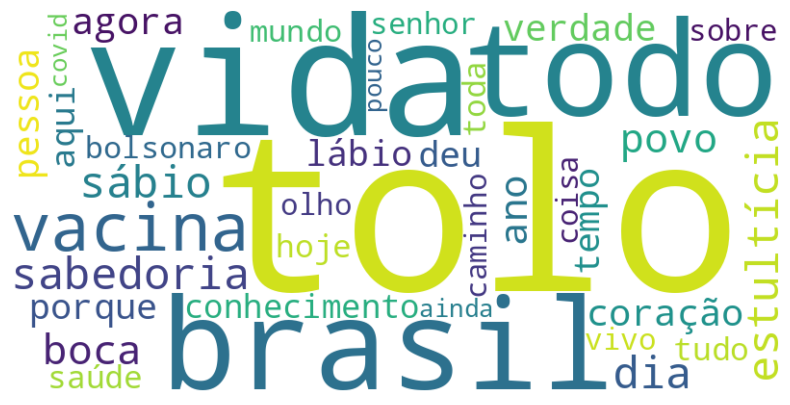

In [ ]:
# Criar a nuvem de palavras
wordcloud = WordCloud(stopwords = except_list,
                      normalize_plurals = True,
                      width = 800,
                      height = 400,
                      background_color = 'white',
                      min_font_size = 25,
                      max_words = 100).generate(all_messages)  # ajuste o número conforme necessário

# Exibir a nuvem de palavras usando Matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

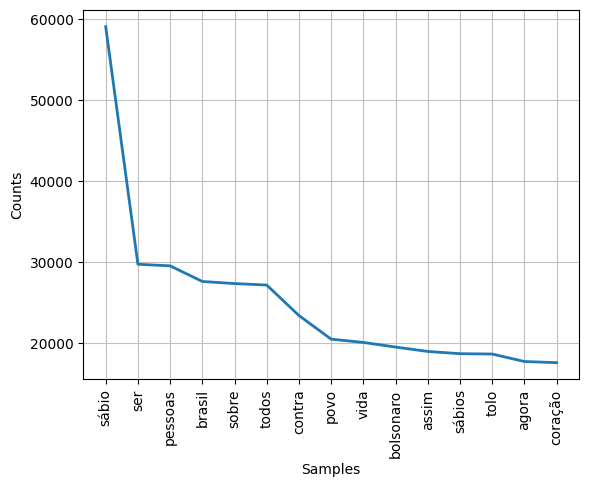

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
# Tokenizar as palavras
words = word_tokenize(all_messages)

# Remover stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(except_list)
words = [word for word in words if word.isalnum() and word not in stop_words]

# Calcular a frequência das palavras
freq_dist = FreqDist(words)
freq_dist.plot(15, cumulative = False)

In [ ]:
# Filtrar mensagens com domain "youtube"
youtube_messages = df[df['domain'] == 'youtube']

youtube_messages.head()

,channel_id,author_id,message_data,message_utc,window_id,message_length,domain
0,-1001034598292,126906048.0,https://www.youtube.com/watch?v=S265ilIKldk,2020-03-05 15:17:36,1,43,youtube
1,-1001034598292,126906048.0,e saiu o gameplay de final fantasy 7 galera,2020-03-05 15:17:35,1,43,youtube
2,-1001034598292,126906048.0,xfce é só amor,2020-03-05 15:17:24,1,14,youtube
3,-1001034598292,126906048.0,Gnome também é,2020-03-05 15:17:20,1,14,youtube
4,-1001034598292,126906048.0,Plasma é bom =D,2020-03-05 15:17:13,1,15,youtube


In [ ]:
len(youtube_messages)

480188

In [ ]:
all_messages_yt = ' '.join(youtube_messages['message_data'].dropna().astype(str).str.lower())

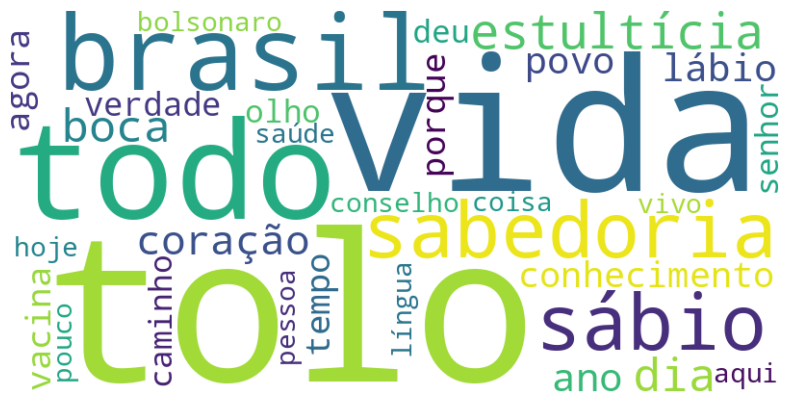

In [ ]:
# Criar a nuvem de palavras
wordcloud = WordCloud(stopwords = except_list,
                      normalize_plurals = True,
                      width = 800,
                      height = 400,
                      background_color = 'white',
                      min_font_size = 25,
                      max_words = 100).generate(all_messages_yt)  # ajuste o número conforme necessário

# Exibir a nuvem de palavras usando Matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Especificar o caminho do arquivo CSV
#csv_path = 'dataset_filtered_youtube.csv'

# Salvar o subdataframe em um arquivo CSV
#youtube_messages.to_csv(csv_path, index = False)

In [ ]:
# Filtrar mensagens com domain "bitchute"
bitchute_messages = df[df['domain'] == 'bitchute']

bitchute_messages.head()

,channel_id,author_id,message_data,message_utc,window_id,message_length,domain
382,-1001034598292,1.692502e+09,https://lbry.com/faq/different-bitchute#:~:tex...,2021-04-10 00:06:19,94,226,bitchute
1013,-1001888844815,NaN,"Thami, encontrei seu canal ha pouco tempo, e a...",2022-11-27 14:44:12,251,3074,bitchute
1084,-1001879999641,1.767316e+09,Lula pertence à mesma elite quer insiste em at...,2022-12-28 22:14:43,286,177,bitchute
1129,-1001876301058,NaN,https://www.bitchute.com/video/bxuPvUCoZmWo/,2023-01-03 03:00:52,324,44,bitchute
1408,-1001866961699,1.655707e+09,https://www.bitchute.com/video/OTrJPLOmhA2S/\n...,2022-12-28 13:59:15,490,381,bitchute


In [ ]:
all_messages_bc = ' '.join(bitchute_messages['message_data'].dropna().astype(str).str.lower())

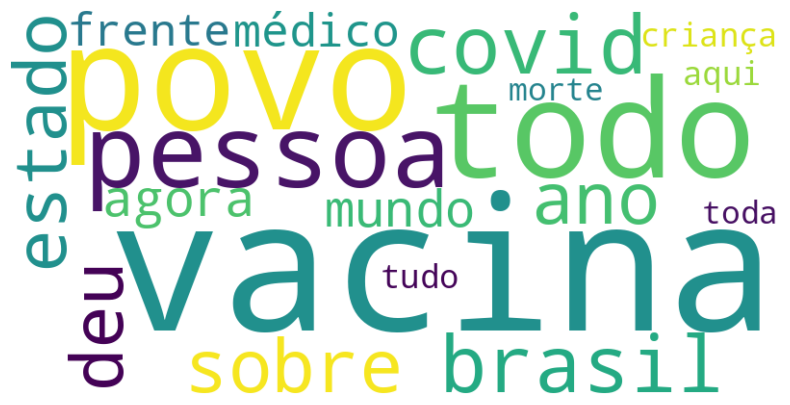

In [ ]:
# Criar a nuvem de palavras
wordcloud = WordCloud(stopwords = except_list,
                      normalize_plurals = True,
                      width = 800,
                      height = 400,
                      background_color = 'white',
                      min_font_size = 25,
                      max_words = 100).generate(all_messages_bc)  # ajuste o número conforme necessário

# Exibir a nuvem de palavras usando Matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Filtrar mensagens com domain "bitchute"
rumble_messages = df[df['domain'] == 'rumble']

rumble_messages.head()

,channel_id,author_id,message_data,message_utc,window_id,message_length,domain
1085,-1001879999641,1.397493e+09,https://rumble.com/v24n146-oeste-sem-filtro-09...,2023-01-09 23:21:57,287,57,rumble
1245,-1001871770426,9.247011e+08,https://rumble.com/v24n146-oeste-sem-filtro-09...,2023-01-09 21:29:31,412,57,rumble
1257,-1001870368434,NaN,https://www.conexaopolitica.com.br/judiciario/...,2023-01-26 04:12:03,420,151,rumble
1258,-1001870368434,NaN,Rumble descumpre decisão de Moraes e mantém pe...,2023-01-26 04:11:57,420,67,rumble
1259,-1001870368434,NaN,Tá faltando o Flávio ver também a lista de tra...,2023-01-26 04:14:50,420,69,rumble


In [ ]:
all_messages_rb = ' '.join(rumble_messages['message_data'].dropna().astype(str).str.lower())

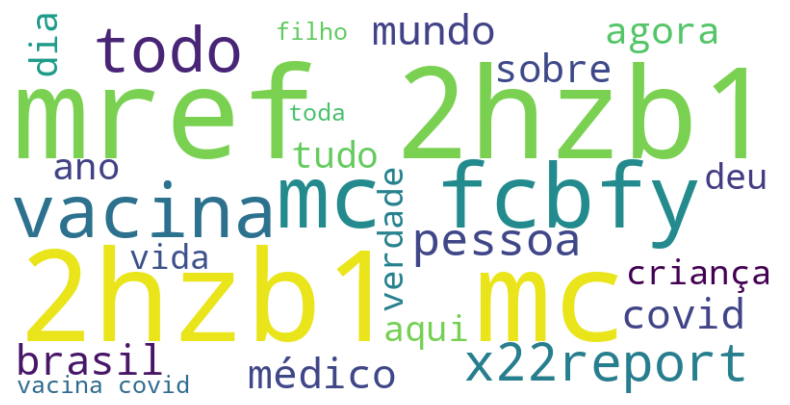

In [ ]:
# Criar a nuvem de palavras
wordcloud = WordCloud(stopwords = except_list,
                      normalize_plurals = True,
                      width = 800,
                      height = 400,
                      background_color = 'white',
                      min_font_size = 25,
                      max_words = 100).generate(all_messages_rb)  # ajuste o número conforme necessário

# Exibir a nuvem de palavras usando Matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Filtrar mensagens com domain "bitchute"
odysee_messages = df[df['domain'] == 'odysee']

odysee_messages.head()

,channel_id,author_id,message_data,message_utc,window_id,message_length,domain
381,-1001034598292,2.596258e+07,https://odysee.com/@debxp:9/mais-que-desrespei...,2021-04-08 11:00:08,93,98,odysee
383,-1001034598292,2.638847e+07,https://odysee.com/@paulobreim:e/I-am-not-a-Ap...,2021-04-10 00:35:49,95,59,odysee
384,-1001034598292,2.638847e+07,"Putz, nem lembrava, já tinha cadastro e ovideo...",2021-04-10 00:35:47,95,60,odysee
385,-1001034598292,1.692502e+09,"hahaha, que otimo, quer dizer que alguem assis...",2021-04-10 00:37:56,95,73,odysee
386,-1001034598292,1.692502e+09,odysee é uma plataforma de visualização do que...,2021-04-10 00:38:16,95,71,odysee


In [ ]:
all_messages_os = ' '.join(odysee_messages['message_data'].dropna().astype(str).str.lower())

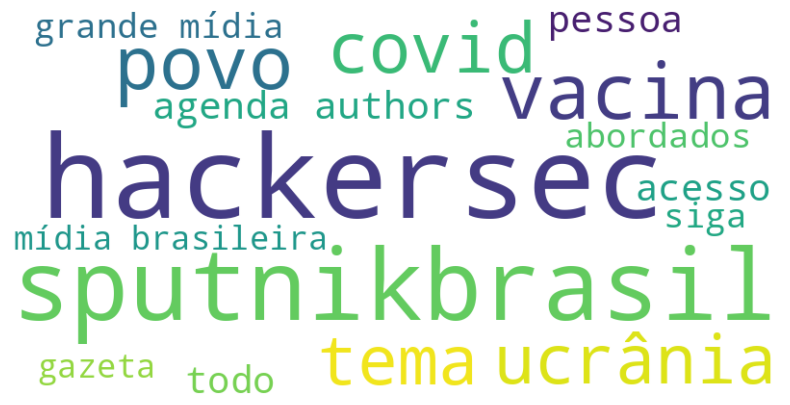

In [ ]:
# Criar a nuvem de palavras
wordcloud = WordCloud(stopwords = except_list,
                      normalize_plurals = True,
                      width = 800,
                      height = 400,
                      background_color = 'white',
                      min_font_size = 25,
                      max_words = 100).generate(all_messages_os)  # ajuste o número conforme necessário

# Exibir a nuvem de palavras usando Matplotlib
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()